Netflix wants to identify similar movies based on movie characteristics.

https://www.kaggle.com/shivamb/netflix-shows

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import umap
from collections import Counter
from wordcloud import WordCloud
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

# Display preference
warnings.filterwarnings('ignore')
pd.set_option('Display.max_columns', 500)
pd.set_option('Display.max_rows', 10000)

In [3]:
netflix = pd.read_csv('../../data/netflix_titles.csv')

## Exploratory Data Analysis (EDA) 

In [4]:
# Initial info
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 12 columns):
show_id         6234 non-null int64
type            6234 non-null object
title           6234 non-null object
director        4265 non-null object
cast            5664 non-null object
country         5758 non-null object
date_added      6223 non-null object
release_year    6234 non-null int64
rating          6224 non-null object
duration        6234 non-null object
listed_in       6234 non-null object
description     6234 non-null object
dtypes: int64(2), object(10)
memory usage: 584.6+ KB


In [5]:
netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


I decided to remove ```netflix['show_id']``` due to its irrelevance and ```netflix['director']``` due to the number of missing values present.

In [6]:
netflix = netflix.drop(['show_id', 'director'], axis=1)
netflix = netflix.dropna(subset=['cast', 'date_added'])

For ```netflix['country']``` and ```netflix['rating']```, missing values were filled with the new value 'Unknown'.

In [7]:
netflix['country'] = netflix['country'].fillna('Unknown')
netflix['rating'] = netflix['rating'].fillna('Unknown')

In ```netflix['description']```, commas were replaced with whitespace to prepare it for later use.

In [8]:
netflix['description'] = netflix['description'].str.replace(',', ' ')

I converted ```netflix['date_added']``` to an ```int``` datatype.

In [9]:
for date in zip(netflix['date_added'].index, netflix['date_added']):
    netflix['date_added'][date[0]] = date[1][-4:]
    
netflix['date_added'] = netflix['date_added'].astype('int64')

### Show Type

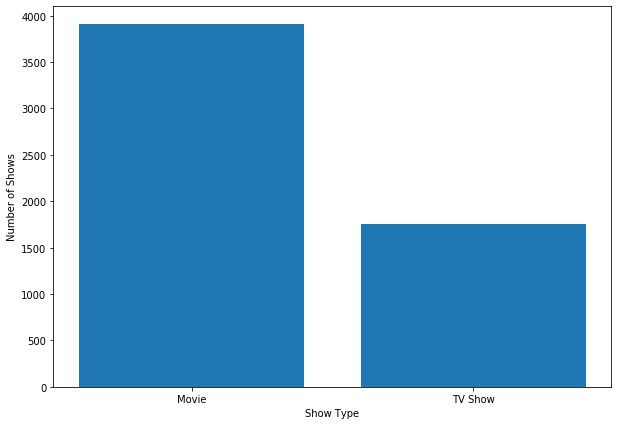

In [10]:
plt.figure(figsize=(10, 7))
plt.bar(netflix.groupby('type')['type'].count().index, netflix.groupby('type')['type'].count())
plt.ylabel('Number of Shows')
plt.xlabel('Show Type')
plt.show()

### Release Year 

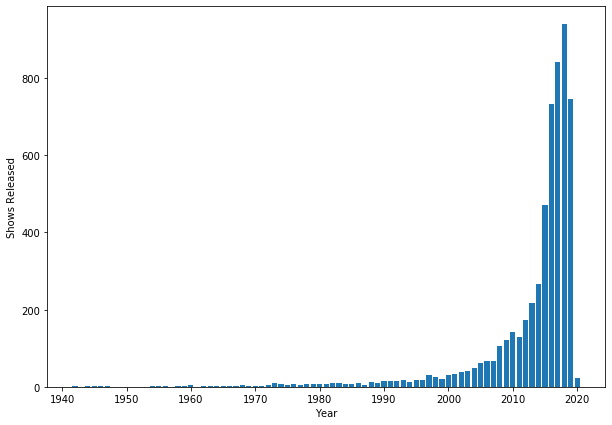

In [11]:
plt.figure(figsize=(10, 7))
plt.bar(netflix.groupby('release_year')['release_year'].count().index, 
        netflix.groupby('release_year')['release_year'].count())
plt.ylabel('Shows Released')
plt.xlabel('Year')
plt.show()

### Show Rating 

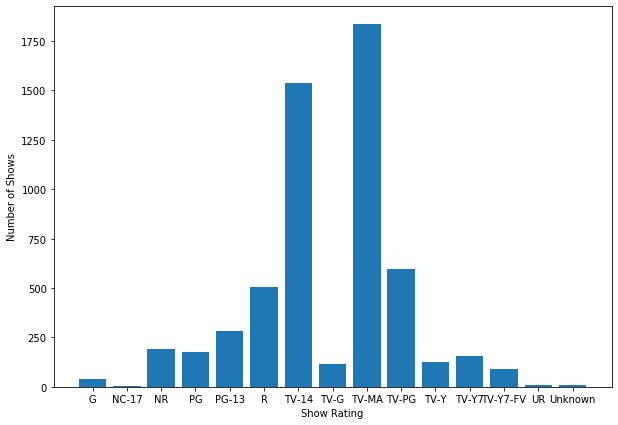

In [12]:
plt.figure(figsize=(10, 7))
plt.bar(netflix.groupby('rating')['rating'].count().index, 
        netflix.groupby('rating')['rating'].count())
plt.ylabel('Number of Shows')
plt.xlabel('Show Rating')
plt.show()

### Creation of Show Category Columns

In [13]:
# Create netflix column labels for show categories
show_categories = set()

for show_category in netflix['listed_in']:
    
    # Create list of show categories
    categories = show_category.split(',')
    
    # Add category to set
    for category in categories:
        show_categories.add(category.strip().lower())

In [14]:
# Create new netflix column labels
for show_category in sorted(show_categories):
    
    # Assign initial value
    netflix[show_category] = False

In [15]:
# Retrieve index for description and tv thrillers
description_index = netflix.columns.tolist().index('description')
tv_thriller_index = netflix.columns.tolist().index('tv thrillers')

# Column list
netflix_show_columns = netflix.columns[(description_index + 1):(tv_thriller_index + 1)].tolist()

In [16]:
for show_category in zip(netflix['listed_in'].index, netflix['listed_in']):
    
    # Create list of show categories
    categories = show_category[1].split(',')
    
    for category in categories:
        
        # Remove whitespace and set to lowercase
        category = category.strip().lower()
        
        # Show category in netflix columns
        if category in netflix_show_columns:
            
            # Update show category value to True
            netflix[category][show_category[0]] = True

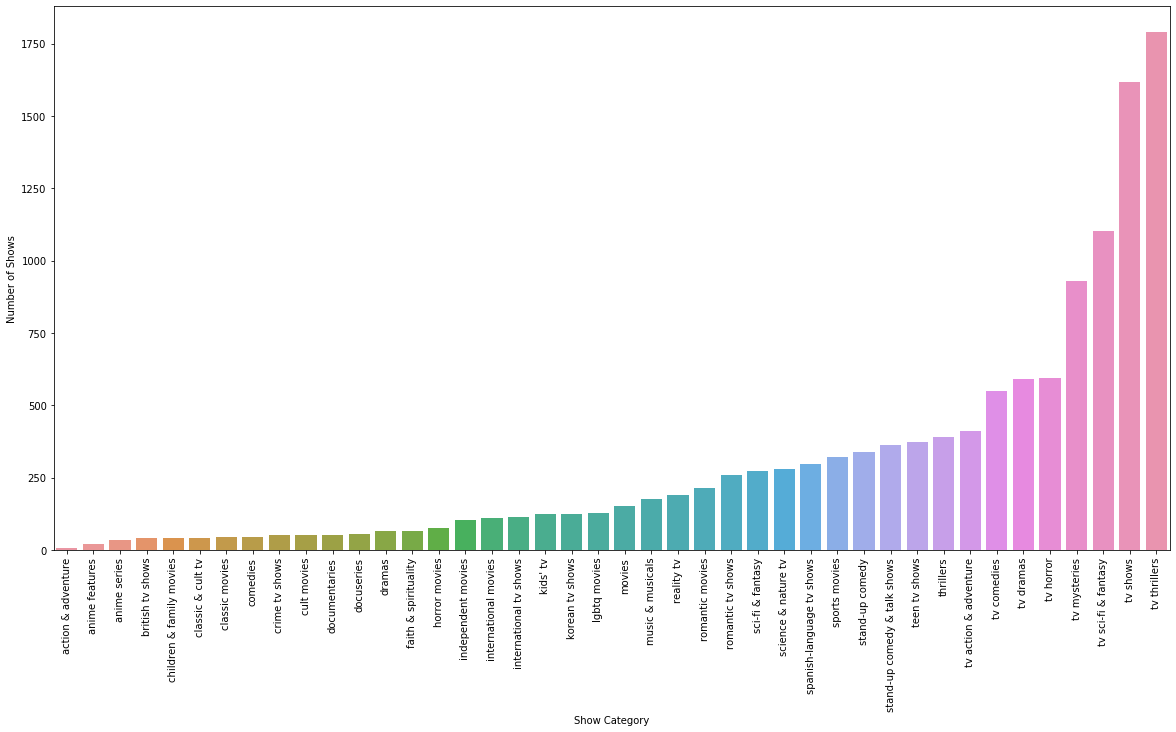

In [17]:
plt.figure(figsize=(20, 10))
sns.barplot(x=netflix_show_columns, y=netflix[netflix_show_columns].sum().sort_values())
plt.ylabel('Number of Shows')
plt.xlabel('Show Category')
plt.xticks(rotation=90)
plt.show()

### Creation of Country Columns

In [18]:
# Create netflix column labels for countries
countries = set()

for country in netflix['country']:
  
    # Create list for show countries
    show_countries = country.split(',')

    # Remove empty string
    if '' in show_countries:
        show_countries.remove('')
    
    # Add show country to countries set
    for show_country in show_countries:
        countries.add(show_country.strip().lower())

In [19]:
# Create new netflix country labels
for country in sorted(countries):
    
    # Assign initial value
    netflix[country] = False

In [20]:
# Retrieve column index for tv thrillers and west germany
tv_thriller_index = netflix.columns.tolist().index('tv thrillers')
west_germany_index = netflix.columns.tolist().index('west germany')

# Column list
netflix_country_columns = netflix.columns[(tv_thriller_index + 1):(west_germany_index + 1)].tolist()

In [21]:
for country in zip(netflix['country'].index, netflix['country']):
    
    # Create list of show countries
    show_countries = country[1].split(',')
    
    for show_country in show_countries:
        
        # Remove whitespace and set to lowercase
        show_country = show_country.strip().lower()
        
        # Show country in netflix columns
        if show_country in netflix_country_columns:
            
            # Update show category value to True
            netflix[show_country][country[0]] = True

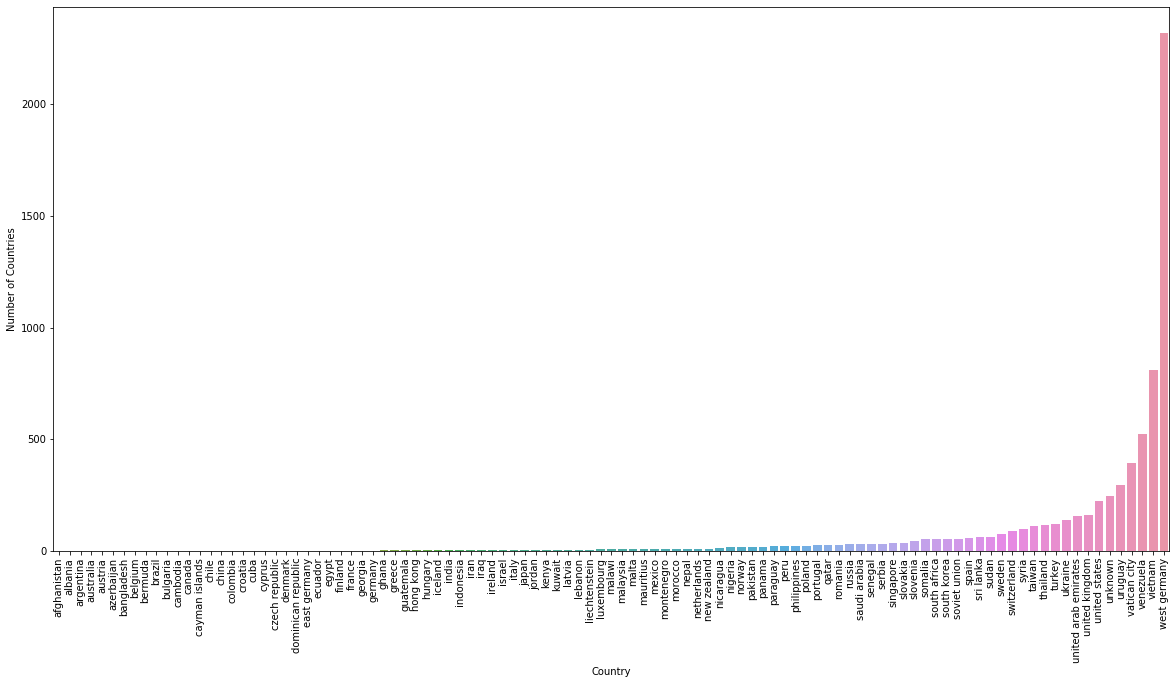

In [22]:
plt.figure(figsize=(20, 10))
sns.barplot(x=netflix_country_columns, y=netflix[netflix_country_columns].sum().sort_values())
plt.ylabel('Number of Countries')
plt.xlabel('Country')
plt.xticks(rotation=90)
plt.show()

### Creation of Keyword Columns

In [23]:
for column in netflix_show_columns:
    
    # Empty string
    column_words = ''
    
    # String to capture all words associated with show category
    for desc in netflix[netflix[column]]['description']:
        column_words += desc
        
    # Create WordCloud object
    wc = WordCloud().generate(column_words)
    
    # Create list of most frequent words
    column_keywords = [keyword for keyword in wc.words_.keys()]
    
    # Create new columns for the to 10 words
    for column_keyword in column_keywords[:10]:
        column_keyword = column_keyword.strip().lower()
        netflix[column_keyword] = False

In [24]:
# Retrieve column index for tv thrillers and west germany
west_germany_index = netflix.columns.tolist().index('west germany')
last_keyword_index = netflix.columns.tolist().index('brother')

# Column list
netflix_keyword_columns = netflix.columns[(west_germany_index + 1):(last_keyword_index + 1)].tolist()

In [25]:
for description in zip(netflix['description'].index, netflix['description']):
    
    # Create list of show description
    show_description = description[1].split(' ')
    
    for desc in show_description:
        
        # Remove whitespace and set to lowercase
        desc = desc.strip().lower()
        
        # Show description in netflix columns
        if desc in netflix_keyword_columns:
            
            # Update show category value to True
            netflix[desc][description[0]] = True

### Creation of Lead Role Columns

In [26]:
netflix_cast = set()

for column in netflix_show_columns:
    
    # Empty list
    column_cast = list()
    
    # String to capture all words associated with show category
    for cast in netflix[netflix[column]]['cast']:
        cast = cast.split(',')
        column_cast += cast

    word_cloud_dict = Counter(column_cast)
        
    # Create WordCloud object
    wc = WordCloud().generate_from_frequencies(word_cloud_dict)

    for key, value in wc.words_.items():
        if value >= 0.5:
            netflix_cast.add(key.strip().lower())

In [27]:
# Create new columns for the to 10 words
for column_cast in netflix_cast:
    netflix[column_cast] = False

In [28]:
# Retrieve column index for tv thrillers and west germany
last_keyword_index = netflix.columns.tolist().index('brother')

# Column list
netflix_cast_columns = netflix.columns[(last_keyword_index + 1):].tolist()

In [29]:
for show_cast in zip(netflix['cast'].index, netflix['cast']):
    
    # Create list of show cast
    cast_members = show_cast[1].split(',')

    for cast in cast_members:
        
        # Remove whitespace and set to lowercase
        cast = cast.strip().lower()
        
        # Show cast in netflix columns
        if cast in netflix_cast_columns:
            
            # Update show cast value to True
            netflix[cast][show_cast[0]] = True

### Last Steps for EDA 

In [30]:
# One-hot encoding
netflix = pd.concat([netflix, pd.get_dummies(netflix['type'], drop_first=True)], axis=1)
netflix = pd.concat([netflix, pd.get_dummies(netflix['rating'], drop_first=True)], axis=1)

In [31]:
# Remove columns that have been transformed
netflix = netflix.drop(['type', 'title', 'cast', 'country', 'rating', 'duration', 'listed_in', 'description'], axis=1)

In [32]:
# Final look at dataset before moving forward
netflix.head()

,date_added,release_year,action & adventure,anime features,anime series,british tv shows,children & family movies,classic & cult tv,classic movies,comedies,crime tv shows,cult movies,documentaries,docuseries,dramas,faith & spirituality,horror movies,independent movies,international movies,international tv shows,kids' tv,korean tv shows,lgbtq movies,movies,music & musicals,reality tv,romantic movies,romantic tv shows,sci-fi & fantasy,science & nature tv,spanish-language tv shows,sports movies,stand-up comedy,stand-up comedy & talk shows,teen tv shows,thrillers,tv action & adventure,tv comedies,tv dramas,tv horror,tv mysteries,tv sci-fi & fantasy,tv shows,tv thrillers,afghanistan,albania,argentina,australia,austria,azerbaijan,bangladesh,belgium,bermuda,brazil,bulgaria,cambodia,canada,cayman islands,chile,china,colombia,croatia,cuba,cyprus,czech republic,denmark,dominican republic,east germany,ecuador,egypt,finland,france,georgia,germany,ghana,greece,guatemala,hong kong,hungary,iceland,india,indonesia,iran,iraq,ireland,israel,italy,japan,jordan,kenya,kuwait,latvia,lebanon,liechtenstein,luxembourg,malawi,malaysia,malta,mauritius,mexico,montenegro,morocco,nepal,netherlands,new zealand,nicaragua,nigeria,norway,pakistan,panama,paraguay,peru,philippines,poland,portugal,qatar,romania,russia,saudi arabia,senegal,serbia,singapore,slovakia,slovenia,somalia,south africa,south korea,soviet union,spain,sri lanka,sudan,sweden,switzerland,syria,taiwan,thailand,turkey,ukraine,united arab emirates,united kingdom,united states,unknown,uruguay,vatican city,venezuela,vietnam,west germany,must,find,two,take,life,cop,young,help,agent,team,ninja,naruto,year,demon,save,group,world,guts,student,mysterious,girl,force,fight,new,friend,series,london,crime,home,family,animal,christmas,make,british,run,town,character,years,returns,woman,war,teen,american,man,love,detective,murder,police,takes,killer,three,day,one,live,plan,documentary,film,explore,career,history,documentary series,travel,stories,father,word,story,faith,god,former,begin,house,horror,turn,adventure,evil,fun,korea,gay,pocoyo,holiday,star,true,musical,music,band,fall,host,compete,show,pop,prize,relationship,romance,earth,discover,human,planet,natural,creature,survive,inside,drug,sport,...,anthony ruivivar,noah schnapp,fabián ríos,ji li,kimberley wong,jespipat tilapornputt,ayden mayeri,heba abdelghany,varun thakur,sasheer zamata,ashley walters,abdelaziz n'mila,sophie simnett,courtenay taylor,danielle cormack,victor lamoglia,pedro casablanc,goo jin,junji majima,catherine siachoque,hilary swank,um apasiri nitibhon,viña machado,warren brown,april liu,julia garner,keiynan lonsdale,danny kim,darren pettie,tae-im lee,mariya ise,emily calandrelli,mamiko noto,kim sun-young,lenny jacobson,austin crute,aaron yoo,jeremy thomas,juan castano,victoria pedretti,tia lee,anupam kher,llorenç gonzález,kate del castillo,byun yo-han,mario zaragoza,nutnicha lueanganankhun,graeme duffy,lee gyoung-young,oliver jackson-cohen,mohammed zeeshan ayyub,thiago ventura,nassim lyes,nigel lindsay,luke mockridge,naomi grossman,kenjiro tsuda,ait youssef youssef,joel mchale,kevin zegers,matthew yang king,carol burnett,eduardo galvão,zhan yi-chun,dallas roberts,chansakorn kittiwattanakorn,mariko hayashi,samantha marie ware,gary grubbs,heather hemmens,haluk bilginer,deforest kelley,mary elizabeth winstead,bruce thomas,jonathan haagensen,chae jung-an,charlie gillespie,kate higgins,shanley caswell,azusa babazono,jak knight,drew massey,julianne moore,alexander calvert,gustavo sánchez parra,david cross,joanna hausmann,lucie boujenah,tina fey,david abraham,murat seviş,katt williams,takahiro sakurai,charlie cox,jason robards,ken marino,jesse moss,b.n. sharma,nanako mori,amber heard,érika mader,omar ghazaoui,hiroyuki ehara,river huang,ragini khanna,deborah ann woll,robert forster,p.j. soles,colin firth,elvira mínguez,matt leblanc,jean smart,leonardo daniel,jaime lorente,genesis rodriguez,pavadee komchokpaisan,engin öztürk,li xiang-yu,liv hew

## Algorithm Selection 

### Clustering 

I'll be comparing K-Means, Hierarchical, DBSCAN and Gaussian Mixture Models clustering algorithms.

### K-Means 

In [34]:
# Function for silhouette score
def score(X_standard, y_predictions):
    print('Silhouette Score is {}'.format(silhouette_score(X_standard, y_predictions, metric='euclidean')))

In [35]:
# Features
X = netflix.copy()

In [36]:
# Standardize features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [38]:
clusters = range(2, 75)

for cluster in clusters:
    
    # Number of clusters
    print('Number of clusters: {}'.format(str(cluster)))
    
    # Define KMeans
    kmeans = KMeans(n_clusters=cluster, random_state=123)

    # Fit model
    kmeans.fit(X_std)

    # Predictions
    kmeans_predictions = kmeans.predict(X_std)
    
    # Metrics
    score(X_std, kmeans_predictions)

Number of clusters: 2
Silhouette Score is 0.8330826815828134
Number of clusters: 3
Silhouette Score is 0.7394712732548292
Number of clusters: 4
Silhouette Score is 0.4219874456380092
Number of clusters: 5
Silhouette Score is 0.6664322919360877
Number of clusters: 6
Silhouette Score is 0.1706336091236594
Number of clusters: 7
Silhouette Score is -0.07797486121261543
Number of clusters: 8
Silhouette Score is 0.520727473743986
Number of clusters: 9
Silhouette Score is 0.720735782208659
Number of clusters: 10
Silhouette Score is 0.3591377765702075
Number of clusters: 11
Silhouette Score is 0.28428849676336165
Number of clusters: 12
Silhouette Score is 0.22490611993225001
Number of clusters: 13
Silhouette Score is 0.38441704694001116
Number of clusters: 14
Silhouette Score is 0.38124865274579856
Number of clusters: 15
Silhouette Score is -0.14207098792295084
Number of clusters: 16
Silhouette Score is 0.4051004479549133
Number of clusters: 17
Silhouette Score is -0.016656550301508647
Number 

### Hierarchical

In [39]:
# Agglomerative clustering (complete)
complete_cosine = AgglomerativeClustering(linkage='complete', affinity='cosine')

# Fit and predictions
complete_cosine_predictions = complete_cosine.fit_predict(X_std)

# Metrics
score(X_std, complete_cosine_predictions)

Silhouette Score is 0.011456291182447297


In [40]:
# Agglomerative clustering (complete)
complete_manhattan = AgglomerativeClustering(linkage='complete', affinity='manhattan')

# Fit and predictions
complete_manhattan_predictions = complete_manhattan.fit_predict(X_std)

# Metrics
score(X_std, complete_manhattan_predictions)

Silhouette Score is 0.8803469516768809


In [41]:
# Agglomerative clustering (ward)
ward_cluster = AgglomerativeClustering(linkage='ward', affinity='euclidean')

# Fit and predictions
ward_predictions = ward_cluster.fit_predict(X_std)

# Metrics
score(X_std, ward_predictions)

Silhouette Score is 0.8803469516768809


In [42]:
# Agglomerative clustering (average)
average_cosine = AgglomerativeClustering(linkage='average', affinity='cosine')

# Fit and predictions
average_cosine_predictions = average_cosine.fit_predict(X_std)

# Metrics
score(X_std, average_cosine_predictions)

Silhouette Score is 0.03822330737799549


In [43]:
# Agglomerative clustering (average)
average_manhattan = AgglomerativeClustering(linkage='average', affinity='manhattan')

# Fit and predictions
average_manhattan_predictions = average_manhattan.fit_predict(X_std)

# Metrics
score(X_std, complete_manhattan_predictions)

Silhouette Score is 0.8803469516768809


### Density-based Spatial Clustering of Applications with Noise (DBSCAN) 

In [45]:
samples = range(1, 15)

for sample in samples:
    
    # Number of samples
    print('Number of samples: {}'.format(str(sample)))

    # Define DBSCAN
    dbscan = DBSCAN(eps=1, min_samples=sample)

    # Fit and predictions
    dbscan_predictions = dbscan.fit_predict(X_std)
    
    score(X_std, dbscan_predictions)

Number of samples: 2
Silhouette Score is -0.41793742820085067
Number of samples: 3
Silhouette Score is -0.42733083333818267
Number of samples: 4
Silhouette Score is -0.43058254919410544
Number of samples: 5
Silhouette Score is -0.4290098631480739
Number of samples: 6


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
samples = range(1, 15)

for sample in samples:
    
    # Number of samples
    print('Number of samples: {}'.format(str(sample)))

    # Define DBSCAN
    dbscan = DBSCAN(eps=2, min_samples=sample)

    # Fit and predictions
    dbscan_predictions = dbscan.fit_predict(X_std)
    
    score(X_std, dbscan_predictions)

### Gaussian Mixture Models (GMM)

In [46]:
components = range(2, 31)

for component in components:
    
    # Number of components
    print('Number of components: {}'.format(str(component)))

    # Define GMM
    gmm = GaussianMixture(n_components=component, random_state=123)

    # Fit and predictions
    gmm_predictions = gmm.fit_predict(X_std)
    
    score(X_std, gmm_predictions)

Number of components: 2
Silhouette Score is -0.07606650860187228
Number of components: 3
Silhouette Score is 0.7107807110371518
Number of components: 4
Silhouette Score is 0.7110196439148224
Number of components: 5
Silhouette Score is 0.7110938661200457
Number of components: 6
Silhouette Score is 0.3240979058424022
Number of components: 7
Silhouette Score is 0.01360371607948752
Number of components: 8
Silhouette Score is -0.16024548231743285
Number of components: 9
Silhouette Score is -0.15970114151626746
Number of components: 10
Silhouette Score is -0.15928548900811695
Number of components: 11
Silhouette Score is -0.1589125403923364
Number of components: 12


KeyboardInterrupt: 

### Dimensionality Reduction 

I'll be comparing PCA, t-SNE and UMAP dimensionality reduction techniques.

### Principal Components Analysis (PCA)

In [ ]:
# Define PCA
pca = PCA(n_components=2)

# Retrieve components by calling fit_transform method with our data
pca_components = pca.fit_transform(X_std)

In [ ]:
# Plot visual
plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

### t-Distributed Stochastic Neighbor Embedding (t-SNE)

In [ ]:
iterations = [250, 300, 350, 400]

for iteration in iterations:
    
    # Number of iterations
    print('Number of iteration: {}'.format(str(iteration)))

    # Define t-SNE
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=iteration)

    # Retrieve components
    tsne_results = tsne.fit_transform(X_std)
    
    # Plot visual
    plt.figure(figsize=(10,5))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

### Uniform Manifold Approximation and Projection (UMAP) 

In [ ]:
neighbors = range(3, 21)

for neighbor in neighbors:
    
    # Number of neighbors
    print('Number of neighbors: {}'.format(str(neighbor)))

    # Define UMAP
    umap_results = umap.UMAP(n_neighbors=neighbor,
                             min_dist=0.3,
                             metric='correlation').fit_transform(X_std)
    
    # Plot visual
    plt.figure(figsize=(10,5))
    plt.scatter(umap_results[:, 0], umap_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()